## Import required packages

In [1]:
from typing import Dict, List, Tuple

import tqdm

import numpy as np
import pandas as pd

import scipy
import scipy.stats

import seaborn as sns
import matplotlib.pyplot as plt
import pylab as p

import pathlib
import tttrlib

import os

#See files in the same directory twodim_hist.py; analysis.py

import twodim_hist as tdh
#import analysis as an

#from decimal import Decimal, getcontext

import numpy.ma as ma
from scipy.stats import norm
from scipy.stats import halfnorm

## Declare required functions

In [2]:
### define a function for extracting the unmasked segments from the thresholded data.
def extract_unmasked_indices(masked_array):
    unmasked_indices_lists = []
    current_indices = []

    # iterate through masked array and collect unmasked index segments
    for i, value in enumerate(masked_array):
        if np.ma.is_masked(value):
            if current_indices:
                unmasked_indices_lists.append(current_indices)
                current_indices = []
        else:
            current_indices.append(i)

    # handle the last segment
    if current_indices:
        unmasked_indices_lists.append(current_indices)

    return unmasked_indices_lists

### Define a Function for running average
def running_average(data, window_size):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')

### Define a function for fluroescence anistoropy
def calc_flour_aniso(g_factor, intensity_para, intensity_perp, l1_japan_corr, l2_japan_corr):
    ### Fluorescence Anisotropy calculation. see equation 7 in Kudryavtsev, V., Sikor, M., Kalinin, S., Mokranjac, D., Seidel, C.A.M. and Lamb, D.C. (2012), 
    ### Combining MFD and PIE for Accurate Single-Pair Förster Resonance Energy Transfer Measurements. ChemPhysChem, 13: 1060-1078. https://doi.org/10.1002/cphc.201100822
    numerator = g_factor * intensity_para - intensity_perp
    denominator = ((1 - 3 * l2_japan_corr) * g_factor * intensity_para +
                   (2 - 3 * l1_japan_corr) * intensity_perp)
    if denominator == 0.0:
        return np.nan
    
    return numerator / denominator


## Load target PTU file

In [3]:
# Load PTU Files
### for testing purposes ###
# FRET, Water, & Buffer 
file_path = pathlib.Path('/Users/hsanabr/Documents/repositories/feda_tools/test data/2024')
file_source = '/Split_20230809_HighFRETDNAStd_1hr_Dani-000000.ptu'
file_water = '/20230809_IRFddH2O_Dani_5min.ptu'
file_buffer = '/20230809_bg_HighFRETDNAStd_30sec_Dani.ptu'
file_ptu = str(file_path) + file_source
file_irf = str(file_path) + file_water
file_bkg = str(file_path) + file_buffer

if file_path.exists():
    print("The path exists.")
else:
    print("The path does not exist.")

The path exists.


## Initialize tttrlib data and extract important global data

In [4]:
#Define macrotimes and microtimes from smFRET file (ptu)
data_ptu = tttrlib.TTTR(file_ptu, 'PTU')
all_macro_times = data_ptu.macro_times
all_micro_times = data_ptu.micro_times
routing_channels =  data_ptu.routing_channels

#Define macrotimes and microtimes from IRF file (ptu)
data_irf = tttrlib.TTTR(file_irf, 'PTU')
all_macro_times_irf = data_irf.macro_times
all_micro_times_irf = data_irf.micro_times
routing_channels_irf =  data_irf.routing_channels

#Define macrotimes and microtimes from Background/Buffer file (ptu)
data_bkg = tttrlib.TTTR(file_bkg, 'PTU')
all_macro_times_bkg = data_bkg.macro_times
all_micro_times_bkg = data_bkg.micro_times
routing_channels_bkg =  data_bkg.routing_channels

#in seconds. usually the first plots are in ms to see the bursts.
macro_res =data_ptu.get_header().macro_time_resolution
micro_res = data_ptu.get_header().micro_time_resolution

# total duration in seconds
total_duration = all_macro_times[-1] * macro_res

# define analysis window for subset of PTU
min_event = 0
max_event = 300000

print("Micro Time Reoslution:", micro_res*10**12, "ps")
print("Macro Time Reoslution:", macro_res*10**9, "ns")

Micro Time Reoslution: 2.0 ps
Macro Time Reoslution: 50.00049078476163 ns


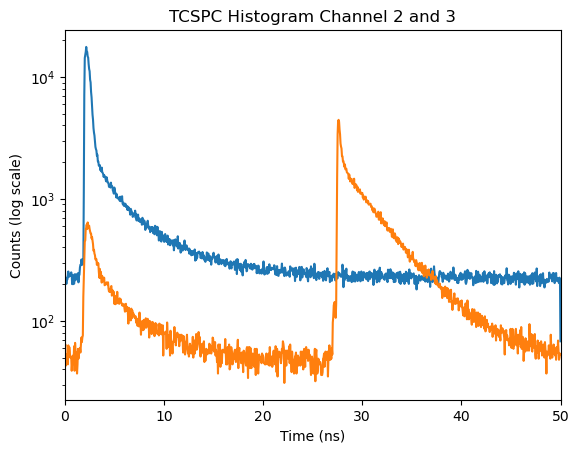

In [5]:
# TCSPC Plot the Micro Time Channel 2 and 3 (Green and Red) for selecting prompt and delay
 # get all the macro times corresponding to the photons in this burst
data_ch2 = data_ptu.get_tttr_by_channel([2]) # Green Parallel 
data_ch3 = data_ptu.get_tttr_by_channel([3]) # Red Parallel 
all_micro_times_channel_2 = data_ch2.micro_times
all_micro_times_channel_3 = data_ch3.micro_times
counts_micro_2, bins = np.histogram(all_micro_times_channel_2*micro_res*10**9, bins=1024) #Units of ns
counts_micro_3, bins = np.histogram(all_micro_times_channel_3*micro_res*10**9, bins=1024) #Units of ns
# Compute bin centers for plotting
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot using semilogy (line plot with log y-axis)
plt.semilogy(bin_centers, counts_micro_2)
plt.semilogy(bin_centers, counts_micro_3)
# Add labels and title
plt.xlim(0, 50)
plt.xlabel('Time (ns)')
plt.ylabel('Counts (log scale)')
plt.title('TCSPC Histogram Channel 2 and 3')

# Show the plot
plt.show()

## Define correction parameters and setting bur, bg4, by4, and br4 calculations.

In [6]:
# photon count threshold for burst selection
min_photon_count = 60
min_photon_count_green = 20

# bg4 parameters (Prompt)
bg4_micro_time_min = 1000 #0 2ns / 2ps = 1000 channels
bg4_micro_time_max = 7000 #12499
bg4_duration = (bg4_micro_time_max - bg4_micro_time_min)*micro_res # In secods

# br4 parameters (Prompt)
br4_micro_time_min = bg4_micro_time_min #0
br4_micro_time_max = bg4_micro_time_max #12499
br4_duration = (br4_micro_time_max - br4_micro_time_min)*micro_res # In secods

# by4 parameters (Delay)
by4_micro_time_min = 13500 #12500
by4_micro_time_max = 18000 #25000
by4_duration = (by4_micro_time_max - by4_micro_time_min)*micro_res # In secods

# flourescence anisotropy parameters
g_factor = 1.04
g_factor_red = 2.5 # To be verified
l1_japan_corr = 0.0308
l2_japan_corr = 0.0368

#bkg signals required for r Scatter calculations - required
bg4_bkg_para = 0
bg4_bkg_perp = 0

br4_bkg_para = 0
br4_bkg_perp = 0

by4_bkg_para = 0
by4_bkg_perp = 0

# MLE parameters
num_bins = 128
bin_width = macro_res/micro_res/num_bins/1000 # in nanoseconds

## Calculate interphoton arrival time 

In [7]:
#iterate through macro and micro times to calculate delta time between photon events
arr_size = len(all_macro_times) - 1
photon_time_intervals = np.zeros(arr_size, dtype = np.float64)
lw = 0.25
for i in range(0, len(photon_time_intervals)):
    photon_1 = (all_macro_times[i]*macro_res) + (all_micro_times[i]*micro_res)
    photon_2 = (all_macro_times[i+1]*macro_res) + (all_micro_times[i+1]*micro_res)
    photon_time_intervals[i] = (photon_2 - photon_1)*1000

# create photon ID array
photon_ids = np.arange(1, arr_size + 1)
print(photon_time_intervals[-1])

0.14390862645541347


## Plot the log of the running average using 2D heat map to better visualize noise

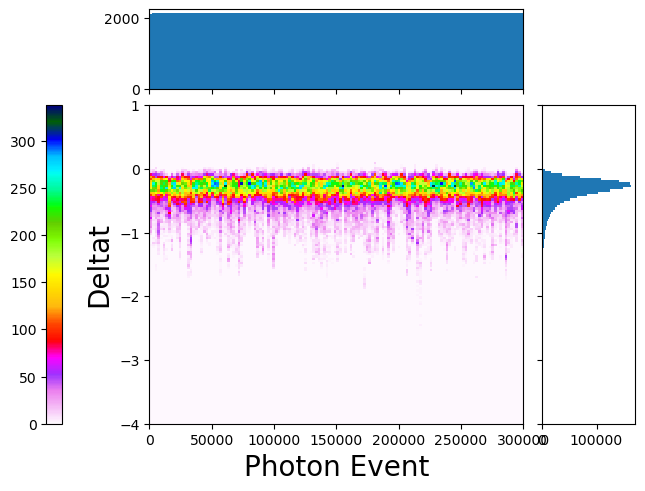

In [25]:
#Calculate Running average
# Create a NumPy array
data = photon_time_intervals

# Set the window size for the running average
window_size = 30

# Calculate the running average
running_avg = running_average(data, window_size)
lw = 0.25
xarr = np.arange(window_size - 1, len(data))
logrunavg = np.log10(running_avg)
# plot the running average as a 2D histogram with 1D histograms on the margins
bins = {"x":141, "y": 141}
xrange = {"min" : min_event, "max" : max_event}
yrange = {"min" : -4, "max" : 1}
fig, ax, twodimdata, x_hist, y_hist = tdh.make_plot(xarr, logrunavg, 'Photon Event','Deltat', xrange, yrange, bins)

## Visually estimate the mean of the Gaussian background noise 


#### Vary the mean value and plot to check if the estimated mean is well aligned with the peak of the noise. The data on the right-half (blue/purple) estimates the right half of the Gaussian noise. The left-most bin of the right-half data is the estimated mean. When the estimated mean is well aligned with the peak, then you may continue to the next step.

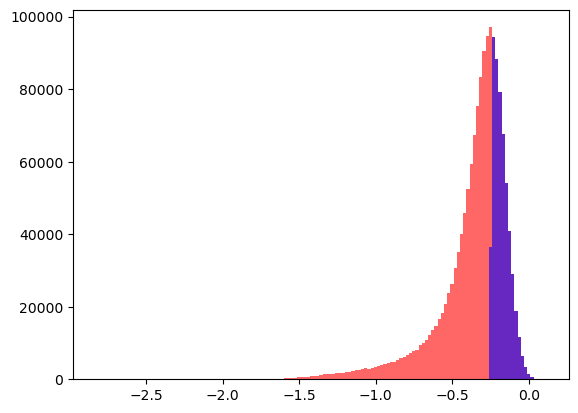

In [9]:
### estimate the half gaussian fit on the top half of the data.
# Histogram running average
counts_logrunavg, bins_logrunavg, _ = plt.hist(logrunavg, bins = bins['y'], alpha=0.6, color='r')

#Find index of the maximum value of the histogram as estimate to set the hal gaussian
# set the threshold based on visual inspection. here, threshold ~ mu
index_max = np.argmax(counts_logrunavg)
noise_mean = bins_logrunavg[index_max]*.95

# compress the filtered data to remove the masked values
filtered_logrunavg = ma.masked_less(logrunavg, noise_mean).compressed()

# Set all masked values to zero

plt.hist(filtered_logrunavg, bins = bins_logrunavg, alpha=0.6, color='b')
plt.show()

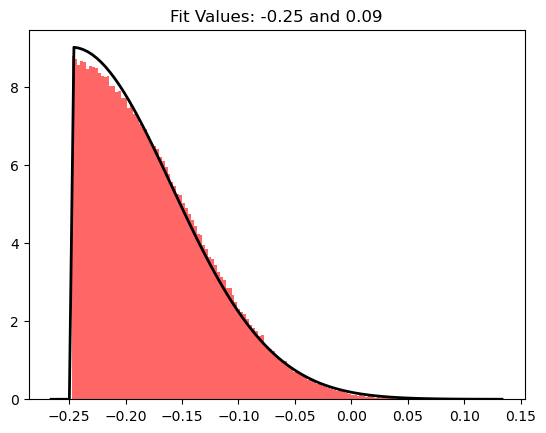

In [10]:
# fit with halfnorm. visualize for best fit testing. get mu and std dev. consider finding max and setting location as mean
mu, std = halfnorm.fit(filtered_logrunavg)

# counts_logrunavg, bins_logrunavg, _ = plt.hist(logrunavg, bins = bins['y'], density= True, alpha=0.6, color='r')
plt.hist(filtered_logrunavg, bins = bins['y'], density = True, alpha=0.6, color='r')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = halfnorm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)

# Display the plot
plt.show()

## Using the halfnorm fit on top half of background noise, define 4sigma threshold to isolate the dynamics data and then plot for inspection.

In [11]:
### Using std from halfnorm fit, set the threshold for filtering out noise. Then, filter out noise. Raise 10 to threshold later for burst selection
threshold_value = mu - 4*std #raise 10 to the power of this threshold to obtain the threshold in Paris.
filtered_values = ma.masked_greater(logrunavg, threshold_value)

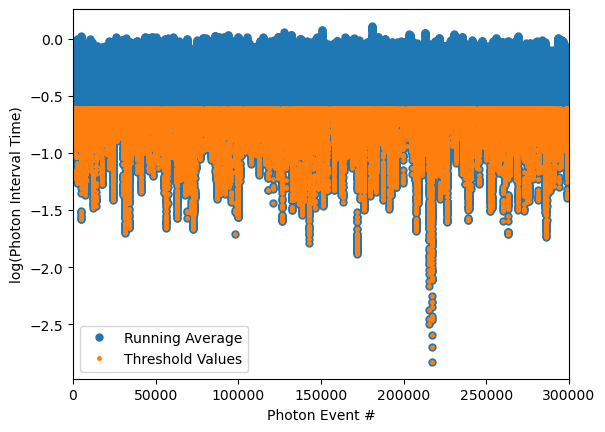

In [12]:
# visualize the log running average and the threshold values
plt.plot(xarr, logrunavg, label='Running Average', linestyle='None', marker = 'o', markersize = 5)
plt.plot(xarr, filtered_values, label='Threshold Values', linestyle='None', marker = '.', markersize = 5)
plt.xlabel('Photon Event #')
plt.ylabel('log(Photon Interval Time)')
plt.legend()
plt.xlim(min_event, max_event)
plt.show()

## Extract the photon data that meets the threshold condition and create a burst index for further calculations

In [13]:
### Get a burst index. Each list is a burst, and each list contains the indices of 
### the photon events in the original data.
burst_index = extract_unmasked_indices(filtered_values)

## Create bi4_bu, bg4, br4, by4 dataframe and calculate statistics

In [14]:
############################################
### create bi4_bur, bg4, by4,  dataframe ###
############################################

# prepare empty dataframes to insert calculated burst values
bi4_bur_df = pd.DataFrame()
bg4_df = pd.DataFrame()
br4_df = pd.DataFrame()
by4_df = pd.DataFrame()

# Initialize list per channels
bg4_channel_2_photons_total = list()
bg4_channel_0_photons_total = list()

br4_channel_3_photons_total = list()
br4_channel_1_photons_total = list()

by4_channel_3_photons_total = list()
by4_channel_1_photons_total = list()


### calculate each burst record and store in df
for burst in burst_index:

    # filter out bursts with one or less photons.
    if len(burst) <= min_photon_count:
        continue

    ############################# .bur calculations
    
    #############################
    ### First and Last Photon ###
    #############################
    
    first_photon = burst[0]
    last_photon = burst[-1]

    ##########################
    ### Duration (ms) calc ###
    ##########################
    
    lp_time = all_macro_times[last_photon]*macro_res + all_micro_times[last_photon]*micro_res
    fp_time = all_macro_times[first_photon]*macro_res + all_micro_times[first_photon]*micro_res
    lp_time_ms = lp_time*1000
    fp_time_ms = fp_time*1000
    duration = (lp_time_ms - fp_time_ms)

    #################################
    ### Mean Macro Time (ms) Calc ###
    #################################
    
    # get all the macro times corresponding to the photons in this burst (Units ms)
    macro_times = all_macro_times[burst[0]]*macro_res*1000
    
    # calculate the mean Un
    mean_macro_time = np.mean(macro_times)

    ##############################
    ### Number of Photons calc ###
    ##############################
    num_photons = len(burst)

    #############################
    ### TOTAL Count Rate calc ###
    #############################
    
    count_rate = num_photons / duration 

    ############################################
    ### Duration (green) and (red) (ms) calc ###
    ###        Prompt and Delay              ###
    ############################################
    
    # Assuming you have your list of indexes
    list_of_indexes = burst
    
    # Create boolean masks for channels 0 and 2 to select the green and red channels
    mask_channel_0 = routing_channels[list_of_indexes] == 0
    mask_channel_2 = routing_channels[list_of_indexes] == 2
    mask_channel_1 = routing_channels[list_of_indexes] == 1
    mask_channel_3 = routing_channels[list_of_indexes] == 3
    
    # Use boolean masks to filter the indexes
    indexes_channel_0 = np.array(list_of_indexes)[mask_channel_0]
    indexes_channel_2 = np.array(list_of_indexes)[mask_channel_2]
    indexes_channel_1 = np.array(list_of_indexes)[mask_channel_1]
    indexes_channel_3 = np.array(list_of_indexes)[mask_channel_3]
    
    # Output the filtered indexes
    # print("Indexes corresponding to channel 0:", indexes_channel_0)
     #print("Indexes corresponding to channel 3:", indexes_channel_3)
    
    # Find the minimum and maximum indexes across both resulting arrays. These are the first and last green 
    # photons in this burst. handle situations where only one channel has photons or none have photons.
    # Considers PROMPT and DELAY microtimes
    
    ### GREEN - Promot and Delay
    if len(indexes_channel_0) > 0 and len(indexes_channel_2) > 0:
        first_green_photon = min(np.min(indexes_channel_0), np.min(indexes_channel_2))
        last_green_photon = max(np.max(indexes_channel_0), np.max(indexes_channel_2))
    elif len(indexes_channel_0) >= 2:
        first_green_photon = np.min(indexes_channel_0)
        last_green_photon = np.max(indexes_channel_0)
    elif len(indexes_channel_2) >= 2:
        first_green_photon = np.min(indexes_channel_2)
        last_green_photon = np.max(indexes_channel_2)
    else:
        first_green_photon = None
        last_green_photon = None

    # Calculate duration (gren) prompt and delay or set as NaN
    if first_green_photon != None and last_green_photon != None:
        lgp_time = all_macro_times[last_green_photon]*macro_res + all_micro_times[last_green_photon]*micro_res
        fgp_time = all_macro_times[first_green_photon]*macro_res + all_micro_times[first_green_photon]*micro_res
        lgp_time_ms = lgp_time*1000
        fgp_time_ms = fgp_time*1000
        duration_green = (lgp_time_ms - fgp_time_ms)
    else:
        duration_green = np.nan

    
    ### RED  - Prompt and Delay
    if len(indexes_channel_1) > 0 and len(indexes_channel_3) > 0:
        first_red_photon = min(np.min(indexes_channel_1), np.min(indexes_channel_3))
        last_red_photon = max(np.max(indexes_channel_1), np.max(indexes_channel_3))
    elif len(indexes_channel_1) >= 2:
        first_red_photon = np.min(indexes_channel_1)
        last_red_photon = np.max(indexes_channel_1)
    elif len(indexes_channel_3) >= 2:
        first_red_photon = np.min(indexes_channel_3)
        last_red_photon = np.max(indexes_channel_3)
    else:
        first_red_photon = None
        last_red_photon = None

    # Calculate duration or set as NaN
    if first_red_photon != None and last_red_photon != None:
        lrp_time = all_macro_times[last_red_photon]*macro_res + all_micro_times[last_red_photon]*micro_res
        frp_time = all_macro_times[first_red_photon]*macro_res + all_micro_times[first_red_photon]*micro_res
        lrp_time_ms = lrp_time*1000
        frp_time_ms = frp_time*1000
        duration_red = (lrp_time_ms - frp_time_ms)
    else:
        duration_red = np.nan



    
    ####################################################
    #### Mean Macro Time (green) and (red) (ms) calc ###
    ####          Considers PROMOT and DELAY         ###
    ####################################################
    
    # get all the macro times corresponding to the photons in this burst (Units ms)
    macro_times_ch0 = all_macro_times[indexes_channel_0]*macro_res*1000
    macro_times_ch2 = all_macro_times[indexes_channel_2]*macro_res*1000
    macro_times_ch1 = all_macro_times[indexes_channel_1]*macro_res*1000
    macro_times_ch3 = all_macro_times[indexes_channel_3]*macro_res*1000

    # Concatenate the arrays along the appropriate axis
    combined_macro_times_green = np.concatenate([macro_times_ch0, macro_times_ch2], axis=0)
    combined_macro_times_red = np.concatenate([macro_times_ch1, macro_times_ch3], axis=0)
    
    # calculate the mean
    mean_macro_time_green = np.mean(combined_macro_times_green, axis=0)
    mean_macro_time_red = np.mean(combined_macro_times_red, axis=0)


    ############################################
    ### Number of Photons (green) and (red)  ###
    ###           Prompt and Delay           ###
    ############################################
    
    num_photons_green = len(indexes_channel_0) + len(indexes_channel_2)
    num_photons_red = len(indexes_channel_1) + len(indexes_channel_3)

    
    #######################################
    ###  Count Rates (green and red)    ###
    ###         Prompt and Delay        ###
    #######################################
   
    count_rate_green = num_photons_green / duration_green
    count_rate_red = num_photons_red / duration_red

    
    ######################## .bg4  .br4  and .by4 calculations

    ################
    ### Ng-p-all ###
    ################

    # Find the indices in burst where the corresponding channel is 2 and 0 < micro time < 12499 using list comprehension
    bg4_channel_2_photons = [index for index in burst if routing_channels[index] == 2 and 
                                 bg4_micro_time_min < all_micro_times[index] < bg4_micro_time_max]
    bg4_channel_2_count = len(bg4_channel_2_photons)

    # append bg4 chn 2 photons to total list for MLE estimations later
    bg4_channel_2_photons_total.extend(bg4_channel_2_photons)


    ################
    ### Ng-s-all ###
    ################

    # Find the indices in burst where the corresponding channel is 0 using list comprehension
    bg4_channel_0_photons = [index for index in burst if routing_channels[index] == 0 and 
                                 bg4_micro_time_min < all_micro_times[index] < bg4_micro_time_max]
    bg4_channel_0_count = len(bg4_channel_0_photons)

    # append bg4 chn 0 photons to total list for MLE estimations later
    bg4_channel_0_photons_total.extend(bg4_channel_0_photons)


    ################
    ### Nr-p-all ###
    ################

    # Find the indices in burst where the corresponding channel is 3 and 0 < micro time < 12499 or selected prompt section using list comprehension
    br4_channel_3_photons = [index for index in burst if routing_channels[index] == 3 and 
                                 br4_micro_time_min < all_micro_times[index] < br4_micro_time_max]
    br4_channel_3_count = len(br4_channel_3_photons)

    # append bg4 chn 3 photons to total list for MLE estimations later
    br4_channel_3_photons_total.extend(br4_channel_3_photons)


    ################
    ### Nr-s-all ###
    ################

    # Find the indices in burst where the corresponding channel is 1 using list comprehension
    br4_channel_1_photons = [index for index in burst if routing_channels[index] == 1 and 
                                 br4_micro_time_min < all_micro_times[index] < br4_micro_time_max]
    br4_channel_1_count = len(br4_channel_1_photons)

    # append bg4 chn 1 photons to total list for MLE estimations later
    br4_channel_1_photons_total.extend(br4_channel_1_photons)


    ################
    ### Ny-p-all ###
    ################

    # Find the indices in burst where the corresponding channel is 3 and 0 < micro time < 12499 or selected prompt section using list comprehension
    by4_channel_3_photons = [index for index in burst if routing_channels[index] == 3 and 
                                 by4_micro_time_min < all_micro_times[index] < by4_micro_time_max]
    by4_channel_3_count = len(by4_channel_3_photons)

    # append bg4 chn 3 photons to total list for MLE estimations later
    by4_channel_3_photons_total.extend(by4_channel_3_photons)


    ################
    ### Ny-s-all ###
    ################

    # Find the indices in burst where the corresponding channel is 1 using list comprehension
    by4_channel_1_photons = [index for index in burst if routing_channels[index] == 1 and 
                                 by4_micro_time_min < all_micro_times[index] < by4_micro_time_max]
    by4_channel_1_count = len(by4_channel_1_photons)

    # append bg4 chn 1 photons to total list for MLE estimations later
    by4_channel_1_photons_total.extend(by4_channel_1_photons)
    
    ##############################################################
    ### Number of Photons (fit window) (green)  (red) (yellow) ###
    ##############################################################

    bg4_total_count = bg4_channel_2_count + bg4_channel_0_count
    br4_total_count = br4_channel_3_count + br4_channel_1_count
    by4_total_count = by4_channel_3_count + by4_channel_1_count


    ###################################################################
    ### Signal (green/promot)  (red/promot) (yellow/delay) (kHz)    ###
    ##################################################################

    bg4_signal_green =  (bg4_total_count / bg4_duration)/1000
    br4_signal_red =  (br4_total_count / br4_duration)/1000
    by4_signal_yellow =  (by4_total_count / by4_duration)/1000

    #################################################
    ### r Experimental (green) (red) and (yellow) ###
    #################################################

    bg4_rexp = calc_flour_aniso(g_factor, bg4_channel_2_count, bg4_channel_0_count, l1_japan_corr, l2_japan_corr)
    br4_rexp = calc_flour_aniso(g_factor_red, br4_channel_3_count, br4_channel_1_count, l1_japan_corr, l2_japan_corr)
    by4_rexp = calc_flour_aniso(g_factor_red, by4_channel_3_count, by4_channel_1_count, l1_japan_corr, l2_japan_corr)

    
    ############################################
    ### r Scatter (green) (red) and (yellow) ###
    ############################################

    bg4_rscat = calc_flour_aniso(g_factor, bg4_channel_2_count - bg4_bkg_para, bg4_channel_0_count - bg4_bkg_perp, l1_japan_corr, l2_japan_corr)
    br4_rscat = calc_flour_aniso(g_factor_red, br4_channel_3_count - br4_bkg_para, br4_channel_1_count - br4_bkg_perp, l1_japan_corr, l2_japan_corr)
    by4_rscat = calc_flour_aniso(g_factor_red, by4_channel_3_count - by4_bkg_para, by4_channel_1_count - by4_bkg_perp, l1_japan_corr, l2_japan_corr)

    ########################################################
    ### Mean Micro time (tau) (green) (red) and (yellow) ###
    ########################################################
    
    if len(bg4_channel_0_photons) + len(bg4_channel_2_photons) <= min_photon_count_green:
        continue
        
    micro_times_channel_0 = all_micro_times[bg4_channel_0_photons]

    # Extract micro times for channel 2 photons
    #micro_times_channel_2 = all_micro_times[bg4_channel_2_photons_total]
    micro_times_channel_2 = all_micro_times[bg4_channel_2_photons]

    # Calculate the mean micro time for channel 0 photons
    mean_micro_time_channel_0 = np.mean(micro_times_channel_0)

    # Calculate the mean micro time for channel 2 photons
    mean_micro_time_channel_2 = np.mean(micro_times_channel_2)

    # Calculate the mean of the means and set min microtime of channel 0 as 0 (Other shifts will be needed here to be more accurate)
    combined_mean_micro_time_green = np.mean([mean_micro_time_channel_0, mean_micro_time_channel_0, mean_micro_time_channel_2])- bg4_micro_time_min



    ##########################################################
    ### create and store new record for this burst bi4_bur ###
    ##########################################################
    
    bur_new_row = {'BurstID': [burst],
                   'First Photon': [first_photon],
                   'Last Photon': [last_photon],
                   'Duration (ms)': [duration],
                   'Mean Macro Time (ms)': [mean_macro_time],
                   'Number of Photons': [num_photons],
                   'Count Rate (kHz)': [count_rate],
                   'Duration (green) (ms)': [duration_green], 
                   'Mean Macro Time (green) (ms)': [mean_macro_time_green],
                   'Number of Photons (green)': [num_photons_green],
                   'Green Count Rate (kHz)': count_rate_green,
                   'Duration (red) (ms)': [duration_red], 
                   'Mean Macro Time (red) (ms)': [mean_macro_time_red],
                   'Number of Photons (red)': [num_photons_red],
                   'Red Count Rate (kHz)': count_rate_red,
                   'Sg (prompt) (kHz)': bg4_signal_green,
                   'Sr (prompt) (kHz)': br4_signal_red,
                   'Sy (delay) (kHz)' : by4_signal_yellow
                  }
    
    bur_new_record = pd.DataFrame.from_dict(bur_new_row)
    
    ### append record to df
    bi4_bur_df = pd.concat([bi4_bur_df, bur_new_record], ignore_index=True)
    
    ######################################################
    ### create and store new record for this burst bg4 ###
    ######################################################

    
    bg4_new_row = {'BurstID': [burst],
                    'Ng-p-all': [bg4_channel_2_count],
                   'Ng-s-all': [bg4_channel_0_count],
                   'Number of Photons (fit window) (green)' : [bg4_total_count],
                   'r Scatter (green)' : [bg4_rscat],
                   'r Experimental (green)' : [bg4_rexp],
                   'Tau (green)' : [combined_mean_micro_time_green*micro_res*10**9]
                  }
    bg4_new_record = pd.DataFrame.from_dict(bg4_new_row)
    
    ### append record to bg4_df
    bg4_df = pd.concat([bg4_df, bg4_new_record], ignore_index=True)

    ######################################################
    ### create and store new record for this burst br4 ###
    ######################################################

    
    br4_new_row = {'BurstID': [burst],
                    'Nr-p-all': [br4_channel_3_count],
                   'Nr-s-all': [br4_channel_1_count],
                   'Number of Photons (fit window) (red)' : [br4_total_count],
                   'r Scatter (red)' : [br4_rscat],
                   'r Experimental (red)' : [br4_rexp]
                  }
    br4_new_record = pd.DataFrame.from_dict(br4_new_row)
    
    ### append record to df
    br4_df = pd.concat([br4_df, br4_new_record], ignore_index=True)

    ######################################################
    ### create and store new record for this burst by4 ###
    ######################################################

    
    by4_new_row = {'BurstID': [burst],
                    'Ny-p-all': [by4_channel_3_count],
                   'Ny-s-all': [by4_channel_1_count],
                   'Number of Photons (fit window) (yellow)' : [by4_total_count],
                   'r Scatter (yellow)' : [by4_rscat],
                   'r Experimental (yellow)' : [by4_rexp]
                  }
    by4_new_record = pd.DataFrame.from_dict(by4_new_row)
    
    ### append record to df
    by4_df = pd.concat([by4_df, by4_new_record], ignore_index=True)

In [15]:
print(bi4_bur_df.columns)
print(bg4_df.columns)
print(br4_df.columns)
print(by4_df.columns)

Index(['BurstID', 'First Photon', 'Last Photon', 'Duration (ms)',
       'Mean Macro Time (ms)', 'Number of Photons', 'Count Rate (kHz)',
       'Duration (green) (ms)', 'Mean Macro Time (green) (ms)',
       'Number of Photons (green)', 'Green Count Rate (kHz)',
       'Duration (red) (ms)', 'Mean Macro Time (red) (ms)',
       'Number of Photons (red)', 'Red Count Rate (kHz)', 'Sg (prompt) (kHz)',
       'Sr (prompt) (kHz)', 'Sy (delay) (kHz)'],
      dtype='object')
Index(['BurstID', 'Ng-p-all', 'Ng-s-all',
       'Number of Photons (fit window) (green)', 'r Scatter (green)',
       'r Experimental (green)', 'Tau (green)'],
      dtype='object')
Index(['BurstID', 'Nr-p-all', 'Nr-s-all',
       'Number of Photons (fit window) (red)', 'r Scatter (red)',
       'r Experimental (red)'],
      dtype='object')
Index(['BurstID', 'Ny-p-all', 'Ny-s-all',
       'Number of Photons (fit window) (yellow)', 'r Scatter (yellow)',
       'r Experimental (yellow)'],
      dtype='object')


## Create Calculated DATA FRAME

In [16]:
# Prepare an empty dataframe to insert calculated burst values
calculated_df = pd.DataFrame()

###############################
###      Sg/Sr (Prompt     ####
###############################
calculated_df['Sg/Sr (prompt)'] = np.where(
    bi4_bur_df['Sr (prompt) (kHz)'] == 0,
    np.nan,
    bi4_bur_df['Sg (prompt) (kHz)'] / bi4_bur_df['Sr (prompt) (kHz)']
)


################################################
###      S(Prompt)/S(Total)   (Fit window)  ####
################################################
calculated_df['S(prompt)/S(total)'] =  np.where(
    bi4_bur_df['Sg (prompt) (kHz)']+bi4_bur_df['Sr (prompt) (kHz)']+bi4_bur_df['Sy (delay) (kHz)'] == 0,
    np.nan,
    (bi4_bur_df['Sg (prompt) (kHz)']+bi4_bur_df['Sr (prompt) (kHz)'])/(bi4_bur_df['Sg (prompt) (kHz)']+bi4_bur_df['Sr (prompt) (kHz)']+bi4_bur_df['Sy (delay) (kHz)'])
)

###############################
###  Efficiency PIE        ####
###############################
#calcualted_df['Efficiency Pie)'] = 

## VIsualize Multiparameters

In [17]:
print(bi4_bur_df.isna().any())
print(bg4_df.isna().any())
print(br4_df.isna().any())
print(by4_df.isna().any())
print(calculated_df.isna().any())

BurstID                         False
First Photon                    False
Last Photon                     False
Duration (ms)                   False
Mean Macro Time (ms)            False
Number of Photons               False
Count Rate (kHz)                False
Duration (green) (ms)           False
Mean Macro Time (green) (ms)    False
Number of Photons (green)       False
Green Count Rate (kHz)          False
Duration (red) (ms)              True
Mean Macro Time (red) (ms)      False
Number of Photons (red)         False
Red Count Rate (kHz)             True
Sg (prompt) (kHz)               False
Sr (prompt) (kHz)               False
Sy (delay) (kHz)                False
dtype: bool
BurstID                                   False
Ng-p-all                                  False
Ng-s-all                                  False
Number of Photons (fit window) (green)    False
r Scatter (green)                         False
r Experimental (green)                    False
Tau (green)     

In [18]:
print(len(bi4_bur_df))
print(len(bg4_df))
print(len(br4_df))
print(len(by4_df))
print(len(calculated_df))
print()

521
521
521
521
521


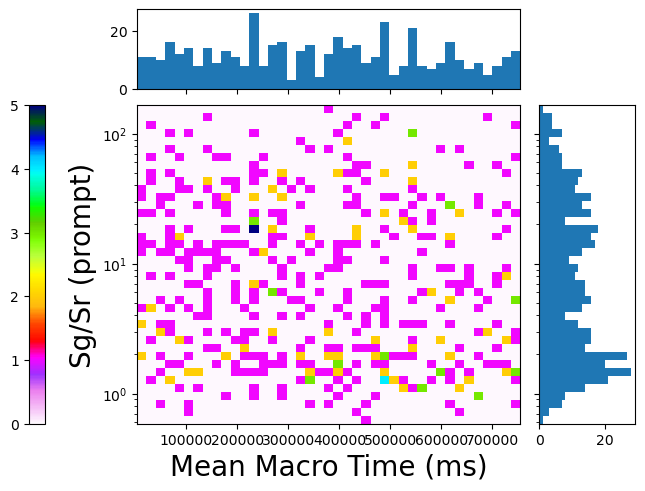

In [26]:
#Plot
### Now you can get the figure, the axes, and the twodim data from make_plot.
### Also, you can give the bin number for x and y using a dictionary.
bins = {"x":41, "y": 41}
x = bi4_bur_df['Mean Macro Time (ms)']
y = calculated_df['Sg/Sr (prompt)']
# Combine into a temprorary DataFrame 
temp_df = pd.concat([x, y], axis=1, keys=['Mean Macro Time (ms)', 'Sg/Sr (prompt)'])
filtered_df = temp_df.dropna()
#Plot
filtered_x = filtered_df['Mean Macro Time (ms)']
filtered_y = filtered_df['Sg/Sr (prompt)']
xrange = {"min" : bi4_bur_df['Mean Macro Time (ms)'].min(), "max" : bi4_bur_df['Mean Macro Time (ms)'].max()}
yrange = {"min" : -4, "max" : 1}
fig, ax, hist_values_2d, nx, ny = tdh.make_plot(filtered_x, filtered_y, 'Mean Macro Time (ms)','Sg/Sr (prompt)', 'auto', 'auto', bins)


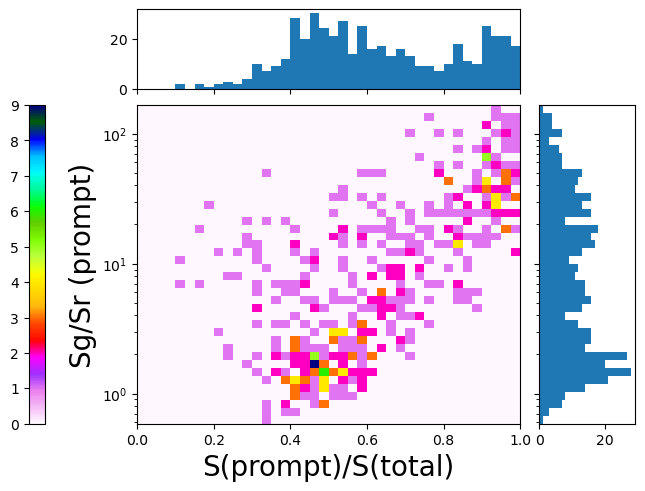

In [29]:
#Plot
### Now you can get the figure, the axes, and the twodim data from make_plot.
### Also, you can give the bin number for x and y using a dictionary.
bins = {"x":41, "y": 41}
x = calculated_df['S(prompt)/S(total)']
y = calculated_df['Sg/Sr (prompt)']
# Combine into a temprorary DataFrame 
temp_df = pd.concat([x, y], axis=1, keys=['S(prompt)/S(total)', 'Sg/Sr (prompt)'])
filtered_df = temp_df.dropna()
#Plot
filtered_x = filtered_df['S(prompt)/S(total)']
filtered_y = filtered_df['Sg/Sr (prompt)']
xrange = {"min" : 0, "max" : 1}
#yrange = {"min" : -1, "max" : 3}
fig, ax, hist_values_2d, nx, ny = tdh.make_plot(filtered_x, filtered_y, 'S(prompt)/S(total)','Sg/Sr (prompt)', xrange, 'auto', bins)


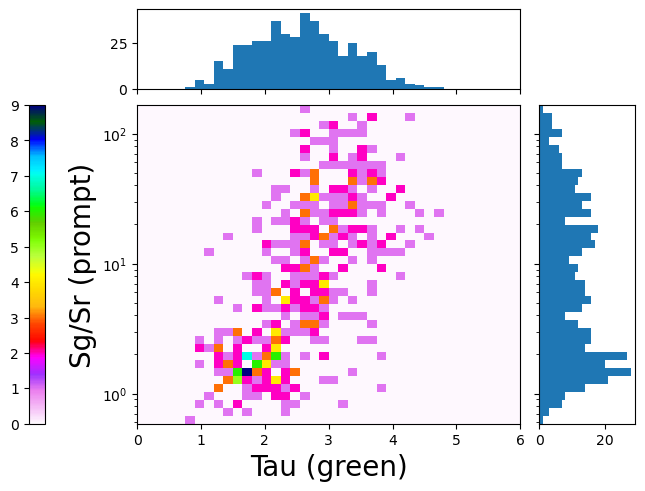

In [30]:
#Plot
### Now you can get the figure, the axes, and the twodim data from make_plot.
### Also, you can give the bin number for x and y using a dictionary.
bins = {"x":41, "y": 41}
x = bg4_df['Tau (green)']
y = calculated_df['Sg/Sr (prompt)']
# Combine into a temprorary DataFrame 
temp_df = pd.concat([x, y], axis=1, keys=['Tau (green)', 'Sg/Sr (prompt)'])
filtered_df = temp_df.dropna()
#Plot
filtered_x = filtered_df['Tau (green)']
filtered_y = filtered_df['Sg/Sr (prompt)']
xrange = {"min" : 0, "max" : 6}
fig, ax, hist_values_2d, nx, ny = tdh.make_plot(filtered_x, filtered_y, 'Tau (green)','Sg/Sr (prompt)', xrange,  'auto', bins)


## Save the bi4_bur, bg4, br4 and by4 to csv

In [20]:
# put output directory at the start
output_directory = r'C:\Users\2administrator\Documents\source\repos\feda_tools\tests\burstid_selection_viz_tool'
bur_filename = os.path.splitext(os.path.basename(str(file_path)))[0]
bur_filepath = os.path.join(output_directory,bur_filename) + ".bur"
bi4_bur_df.to_csv(bur_filepath, sep='\t', index=False, float_format='%.6f')  # Save without index

NameError: name 'file_p' is not defined

In [ ]:
bur_filename = os.path.splitext(os.path.basename(str(file_path)))[0]
bur_filepath = os.path.join(output_directory,bur_filename) + ".bg4"
bg4_df.to_csv(bur_filepath, sep='\t', index=False, float_format='%.6f')  # Save without index

## Mean Micro Time Testing

In [36]:
#import numpy as np

# Assuming you have the arrays: bg4_channel_0_photons, bg4_channel_2_photons, and all_micro_times

# Extract micro times for channel 0 photons
micro_times_channel_0 = all_micro_times[bg4_channel_0_photons]

# Extract micro times for channel 2 photons
micro_times_channel_2 = all_micro_times[bg4_channel_2_photons]

# photon counts
count_chn0 = len(bg4_channel_0_photons)
count_chn2 = len(bg4_channel_2_photons)

#p and s mean micro times
mean_microtime_chn0 = np.mean(micro_times_channel_0)
mean_microtime_chn2 = np.mean(micro_times_channel_2)

mean_microtime_total = ( count_chn2 * mean_microtime_chn2 + 2 * count_chn0 * mean_microtime_chn0 ) / ( count_chn2 + 2 * count_chn0 )

# Output the combined mean micro time
print("mean micro time for channels 0 and 2 photons:", mean_microtime_total)

mean micro time for channels 0 and 2 photons: 3044.377049180328


Combined mean micro time for channels 0 and 2 photons: 5.520530443756451


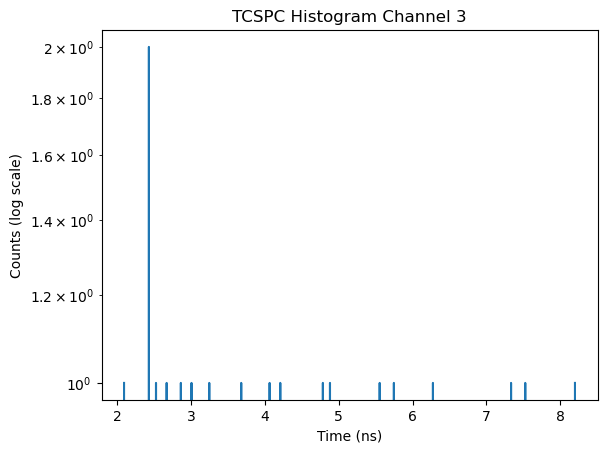

In [137]:
#import numpy as np

# Assuming you have the arrays: bg4_channel_0_photons, bg4_channel_2_photons, and all_micro_times

# Extract micro times for channel 0 photons
#micro_times_channel_0 = all_micro_times[bg4_channel_0_photons_total]
micro_times_channel_0 = all_micro_times[bg4_channel_0_photons]

# Extract micro times for channel 2 photons
#micro_times_channel_2 = all_micro_times[bg4_channel_2_photons_total]
micro_times_channel_2 = all_micro_times[bg4_channel_2_photons]

# Calculate the mean micro time for channel 0 photons
mean_micro_time_channel_0 = np.mean(micro_times_channel_0)

# Calculate the mean micro time for channel 2 photons
mean_micro_time_channel_2 = np.mean(micro_times_channel_2)

# Calculate the mean of the means
combined_mean_micro_time = np.mean([mean_micro_time_channel_0, mean_micro_time_channel_2, mean_micro_time_channel_2])

# Output the combined mean micro time
print("Combined mean micro time for channels 0 and 2 photons:", combined_mean_micro_time*micro_res*10**9)

# TCSPC Plot the Micro Time Channel 3
counts_micro_0, bins = np.histogram(micro_times_channel_0*micro_res*10**9, bins=128)
# Compute bin centers for plotting
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot using semilogy (line plot with log y-axis)
plt.semilogy(bin_centers, counts_micro_0)

# Add labels and title
plt.xlabel('Time (ns)')
plt.ylabel('Counts (log scale)')
plt.title('TCSPC Histogram Channel 3')

# Show the plot
plt.show()

## Visualize the micro time decay curves for the entire bg4 data set.

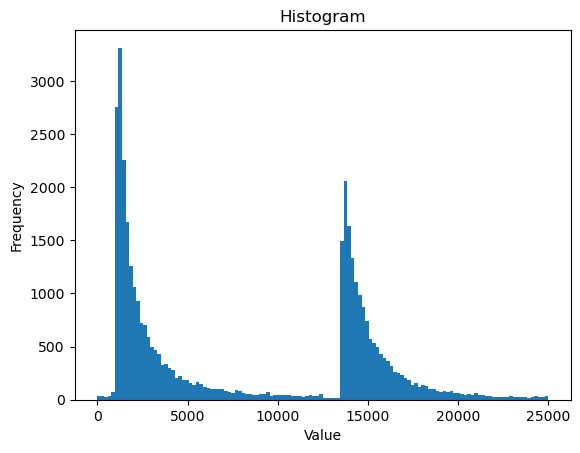

In [38]:
# This data can be used prior to performing burst by burst mle fitting to determine the initial fitting parameters tau, gamma, r0, and rho.

### plot the histogram of the ptu file

# Add 12499 to parallel photon microtimes
micro_times_channel_0_shifted = micro_times_channel_0 + 12499

# Extract micro times for channel 2 photons
micro_times_channel_2 = all_micro_times[bg4_channel_2_photons_total]

chn0_shifted_plus_chn2 = np.concatenate([micro_times_channel_0_shifted, micro_times_channel_2])

num_bins = 128
# Plot the histogram with 128 bins
counts, bins, _ = plt.hist(chn0_shifted_plus_chn2, bins=num_bins)


# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Show the plot
plt.show()

# Extract the binned data
# print("Counts for each bin:", counts)
# print("Bin edges:", bins)

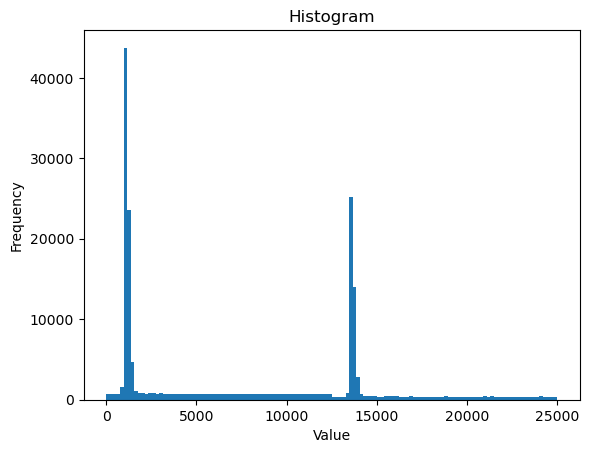

In [39]:
### plot the histogram of the irf

# Find the indices in IRF where the corresponding channel is 2 and 0 
channel_2_photons_irf = [index for index, channel in enumerate(routing_channels_irf) if channel == 2 and 
                                 bg4_micro_time_min < all_micro_times_irf[index] < bg4_micro_time_max]
channel_0_photons_irf = [index for index, channel in enumerate(routing_channels_irf) if channel == 0 and 
                                 bg4_micro_time_min < all_micro_times_irf[index] < bg4_micro_time_max]

# Add 12499 to parallel photon microtimes
micro_times_channel_0_irf = all_micro_times_irf[channel_0_photons_irf]
micro_times_channel_0_shifted_irf = micro_times_channel_0_irf + 12499

# Extract micro times for channel 2 photons
micro_times_channel_2_irf = all_micro_times_irf[channel_2_photons_irf]

# Combine channel 0 and 2 irf data for plotting
chn0_shifted_plus_chn2_irf = np.concatenate([micro_times_channel_0_shifted_irf, micro_times_channel_2_irf])

# Plot the irf data
counts_irf, bins_irf, _ = plt.hist(chn0_shifted_plus_chn2_irf, bins=num_bins)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Show the plot
plt.show()

# Extract the binned data
# print("Counts for each bin:", counts)
# print("Bin edges:", bins)

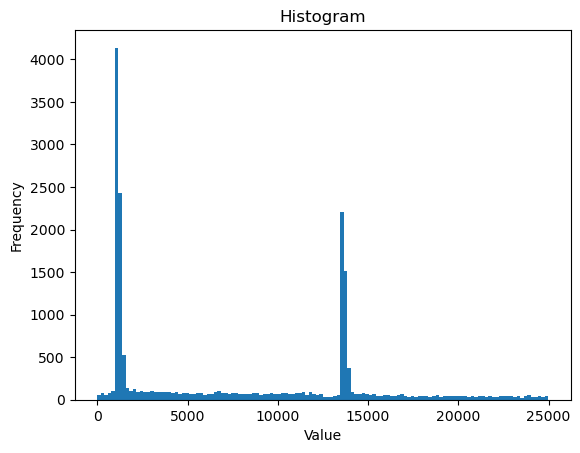

In [40]:
### plot the histogram of the bkg

# Find the indices in bkg where the corresponding channel is 2 and 0 
channel_2_photons_bkg = [index for index, channel in enumerate(routing_channels_bkg) if channel == 2 and 
                                 bg4_micro_time_min < all_micro_times_bkg[index] < bg4_micro_time_max]
channel_0_photons_bkg = [index for index, channel in enumerate(routing_channels_bkg) if channel == 0 and 
                                 bg4_micro_time_min < all_micro_times_bkg[index] < bg4_micro_time_max]

# Add 12499 to parallel photon microtimes
micro_times_channel_0_bkg = all_micro_times_bkg[channel_0_photons_bkg]
micro_times_channel_0_shifted_bkg = micro_times_channel_0_bkg + 12499

# Extract micro times for channel 2 photons
micro_times_channel_2_bkg = all_micro_times_bkg[channel_2_photons_bkg]

# Combine channel 0 and 2 bkg data for plotting
chn0_shifted_plus_chn2_bkg = np.concatenate([micro_times_channel_0_shifted_bkg, micro_times_channel_2_bkg])

# Plot the bkg data
counts_bkg, bins_bkg, _ = plt.hist(chn0_shifted_plus_chn2_bkg, bins=num_bins)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Show the plot
plt.show()

# Extract the binned data
# print("Counts for each bin:", counts)
# print("Bin edges:", bins)

## Estimate tau, gamma, r0, and rho using fit23

In [49]:
print(num_bins)

128


Results
tau: 1.60
gamma: 0.00
r0: 0.38
rho: 0.40
softbifl: -1.00
2I*: P+2S: 1.00
rs_scatter: 0.08
rs_exp: 0.08


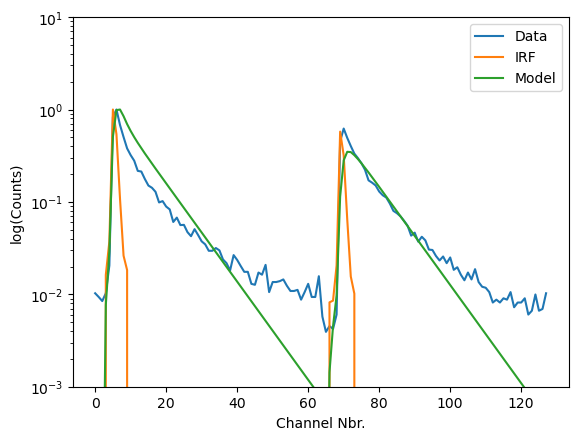

In [48]:
# estimate tau, gamma, r0, and rho using fit23

# is the width of the bins in time
dt = 25000/num_bins/1000

# period is pulse duration of the laser (50ns)
period = 1/macro_res/np.power(10,6)

# irf_np = np.zeros_like(counts)

# irf_np = np.array([260, 158200000, 155, 0, 0, 0, 0, 0, 0, 0,
#                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#                    0, 22, 107400000, 830, 10, 0, 0, 0, 0, 0,
#                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#                    0, 0, 0, 0], dtype=np.float64)

# count_bkg = np.zeros_like(counts_irf)

#### SET IRF to zero from channel 5 to channl 64 and 70 to 128 to remove IRF background
counts_irf_nb = counts_irf
counts_irf_nb[0:3] = 0
counts_irf_nb[10:66] = 0
counts_irf_nb[74:128] = 0

fit23 = tttrlib.Fit23(
    dt=dt,
    # irf=irf_np,
    irf=counts_irf_nb,
    background= np.ones_like(counts_irf_nb)*1,
    period=period,
    g_factor=g_factor,
    l1=l1_japan_corr, l2=l2_japan_corr,
    convolution_stop = 8,
    p2s_twoIstar_flag = True
)

# normalize counts
#norm_counts = counts/np.max(counts) # normalize by maximum
norm_counts = counts/np.sum(counts) # normaalized by sum

tau, gamma, r0, rho = 3.03, 0.02, 0.38, 1.64
x0 = np.array([tau, gamma, r0, rho])
fixed = np.array([0, 0, 1, 0])
r2 = fit23(data=counts, initial_values=x0, fixed=fixed, include_model = True)
# output key from DecayFit23.h on tttrlib github.
# x[0] fluorescence lifetime - tau;
# x[1] fraction of scattered light - gamma;
# x[2] fundamental anisotropy - r0
# x[3] rotational time - rho;
# x[4] softbifl - flag specifying the type of bifl fit (not used here)
# x[5] p2s_twoIstar - flag specifying the type of chi2 calculation (not used here)
# x[6] background corrected anisotropy
# x[7] anisotropy without background correction
print("Results")
print("=======")
print("tau: {:.2f}".format(r2['x'][0]))
print("gamma: {:.2f}".format(r2['x'][1]))
print("r0: {:.2f}".format(r2['x'][2]))
print("rho: {:.2f}".format(r2['x'][3]))
print("softbifl: {:.2f}".format(r2['x'][4]))
print("2I*: P+2S: {:.2f}".format(r2['x'][5]))
print("rs_scatter: {:.2f}".format(r2['x'][6]))
print("rs_exp: {:.2f}".format(r2['x'][6]))
# %matplotlib qt
counts_model = [x for x in fit23.model]
plt.semilogy([x for x in fit23.data]/np.max(counts), label='Data')
plt.semilogy(counts_irf/np.max(counts_irf), label='IRF')
#plt.semilogy([x for x in fit23.irf]/np.max(counts_irf), label='IRF')
plt.semilogy(counts_model/np.max(counts_model), label='Model')
# Set the y-axis limits
plt.ylim(0.001, np.power(10,1))
# plt.title.set_text(r'Example decay')
plt.ylabel(r'log(Counts)')
plt.xlabel(r'Channel Nbr.')
plt.legend()

In [49]:
#import pylab as p

# estimate using MLE example 2

# is the width of the bins in time
dt = 25000/num_bins/1000

# period is pulse duration of the laser (50ns)
period = 1/macro_res/np.power(10,6)

# irf_np = np.zeros_like(counts)

# irf_np = np.array([260, 158200000, 155, 0, 0, 0, 0, 0, 0, 0,
#                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#                    0, 22, 107400000, 830, 10, 0, 0, 0, 0, 0,
#                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#                    0, 0, 0, 0], dtype=np.float64)

count_bkg = np.zeros_like(counts_irf)

# conv_stop = num_bins // 2 /- 1
conv_stop = 18


corrections = np.array([period, g_factor, l1_japan_corr, l2_japan_corr, conv_stop])
m_param = tttrlib.CreateMParam(
    irf=counts_irf,
    background=counts_bkg,
    data = counts.astype(np.int32),
    corrections = corrections,
    dt=dt
)


tau, gamma, r0, rho = 4.0, 0.01, 0.38, 1.5
bifl_scatter = -1
p_2s = 0

x = np.zeros(8, dtype=np.float64)
x[:6] = [tau, gamma, r0, rho, bifl_scatter, p_2s]

fixed = np.array([0, 1, 1, 1], dtype=np.int16)
chi2 = tttrlib.DecayFit23.fit(x, fixed, m_param)

m = np.array([m for m in m_param.get_model()])
p.semilogy(m)
p.semilogy(counts)
p.semilogy(counts_irf / max(counts_irf) * max(counts))
plt.legend()
p.show()

print(m_param)

NameError: name 'counts_bkg' is not defined

## Use MLE data to 

In [27]:
# from plot fit23 benchmark article online

param = np.array([3.03, 0.24, 0.38, 0.64])

# flourescence anisotropy parameters
g_factor = 1.04
l1_japan_corr = 0.0308
l2_japan_corr = 0.0368
conv_stop = 6

corrections = np.array([period, g_factor, l1_japan_corr, l2_japan_corr, conv_stop])
model = np.zeros_like(counts_irf)
tttrlib.DecayFit23.modelf(param, counts_irf, counts_bkg, dt, corrections, model)

# n_photons = len(chn0_shifted_plus_chn2) # normalize for some reason. see tttrlib fit23 benchmark article.
# model *= n_photons / np.sum(model)
# data = np.random.poisson(model * n_photons)
# plt.plot(data)

0

In [30]:
# get MLE to fit mean micro time decays. extract model parameters. use to fit each burst and extract lifetimes from bursts.
# how many bursts per second are selected and how many bursts per seconds after filter. before and after thresdhol, what is the burst per second? Single molecule order of mag is 2-3 burst per second byt the time you have lifetimes.

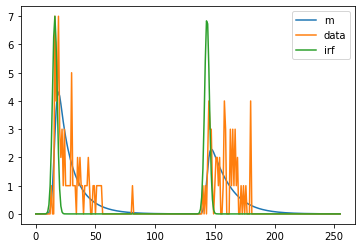

In [29]:
#import tttrlib
#import numpy as np
#import scipy.stats
#import pylab as p


def model_irf(
        n_channels: int = 256,
        period: float = 32,
        irf_position_p: float = 2.0,
        irf_position_s: float = 18.0,
        irf_width: float = 0.25
):
    time_axis = np.linspace(0, period, n_channels * 2)
    irf_np = scipy.stats.norm.pdf(time_axis, loc=irf_position_p, scale=irf_width) + \
             scipy.stats.norm.pdf(time_axis, loc=irf_position_s, scale=irf_width)
    return irf_np, time_axis


# setup some parameters
n_channels = 128
n_corrections = 5
n_photons = 120
irf_position_p = 2.0
irf_position_s = 18.0
irf_width = 0.25
period, g, l1, l2, conv_stop = 32, 1.0, 0.1, 0.1, n_channels // 2 - 1
tau, gamma, r0, rho = 2.0, 0.01, 0.38, 1.2
np.random.seed(0)

irf_np, time_axis = model_irf(
    n_channels=n_channels,
    period=period,
    irf_position_p=irf_position_p,
    irf_position_s=irf_position_s,
    irf_width=irf_width
)
dt = time_axis[1] - time_axis[0]
conv_stop = min(len(time_axis), conv_stop)
param = np.array([tau, gamma, r0, rho])
corrections = np.array([period, g, l1, l2, conv_stop])

# compute a model function that is later used as "data"
model = np.zeros_like(time_axis)
bg = np.zeros_like(time_axis)
tttrlib.DecayFit23.modelf(param, irf_np, bg, dt, corrections, model)
# add poisson noise to model and use as data
data = np.random.poisson(model * n_photons)

# create MParam structure that contains all parameters for fitting
m_param = tttrlib.CreateMParam(
    irf=irf_np,
    background=bg,
    data=data.astype(np.int32),
    corrections=corrections,
    dt=dt
)

tau, gamma, r0, rho = 4., 0.01, 0.38, 1.5
bifl_scatter = -1
p_2s = 0
x = np.zeros(8, dtype=np.float64)
x[:6] = [tau, gamma, r0, rho, bifl_scatter, p_2s]

# test fitting
fixed = np.array([0, 1, 1, 1], dtype=np.int16)
chi2 = tttrlib.DecayFit23.fit(x, fixed, m_param)

m = np.array([m for m in m_param.get_model()])
p.plot(m, label = 'm')
p.plot(data, label = 'data')
p.plot(irf_np / max(irf_np) * max(data), label = 'irf')
plt.legend()
p.show()

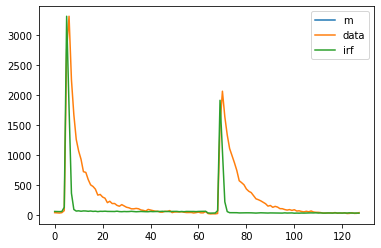

In [30]:
# create MParam structure that contains all parameters for fitting
# is the width of the bins in time
dt = 25000/num_bins/1000

# period is pulse duration of the laser (50ns)
period = 1/macro_res/np.power(10,6)

# flourescence anisotropy parameters
g_factor = 1.04
l1_japan_corr = 0.0308
l2_japan_corr = 0.0368
conv_stop = 128
corrections = np.array([period, g_factor, l1_japan_corr, l2_japan_corr, conv_stop])

data = counts

m_param = tttrlib.CreateMParam(
    irf=counts_irf,
    background=counts_bkg,
    data=data.astype(np.int32),
    corrections=corrections,
    dt=dt
)

tau, gamma, r0, rho = 3.03, 0.24, 0.38, 0.64
bifl_scatter = 0
p_2s = 1
x = np.zeros(8, dtype=np.float64)
x[:6] = [tau, gamma, r0, rho, bifl_scatter, p_2s]

# test fitting
fixed = np.array([0, 0, 1, 0], dtype=np.int16)
chi2 = tttrlib.DecayFit23.fit(x, fixed, m_param)

m = np.array([m for m in m_param.get_model()])
plt.plot(m, label = 'm')
plt.plot(data, label = 'data')
plt.plot(counts_irf / max(counts_irf) * max(data), label = 'irf')
plt.legend()
plt.show()

(10, 100000)

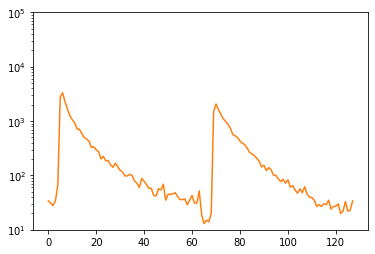

In [31]:
plt.semilogy([x for x in m], label = 'm')
plt.semilogy([x for x in data], label = 'data')
# plt.semilogy([x for x in fit23.model], label='Model')
# Set the y-axis limits
plt.ylim(10, 100000)